In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest


In [3]:
from world import World
from grid_data import Rainfall, SurfaceTemperature
from utils import movmean

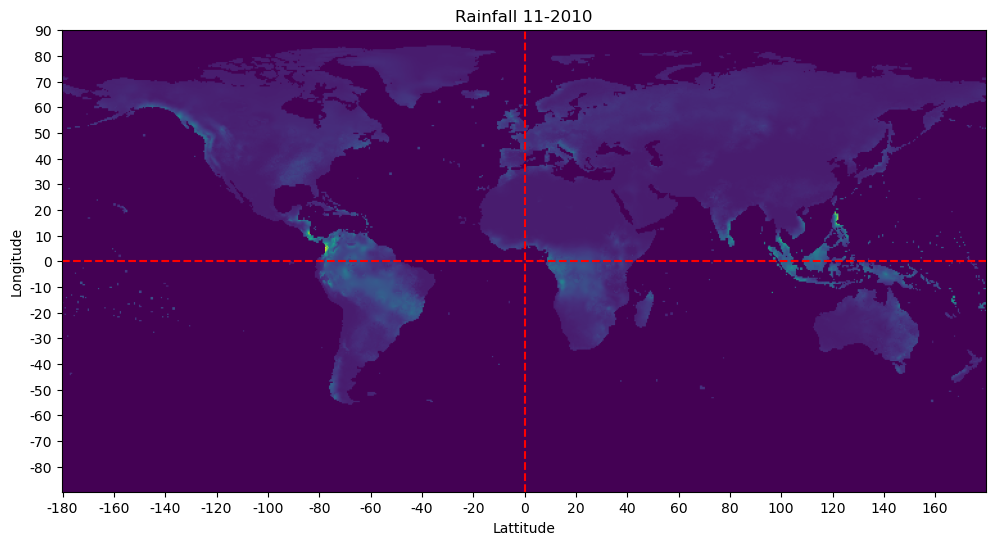

In [4]:
# fetch data
rainfall = Rainfall()
rainfall.fetch_data_years(1901, 2023, delete_file=True)

# get 2001 january for the entire world and plot
ax = rainfall.plot_month(11, 2010)
plt.show()

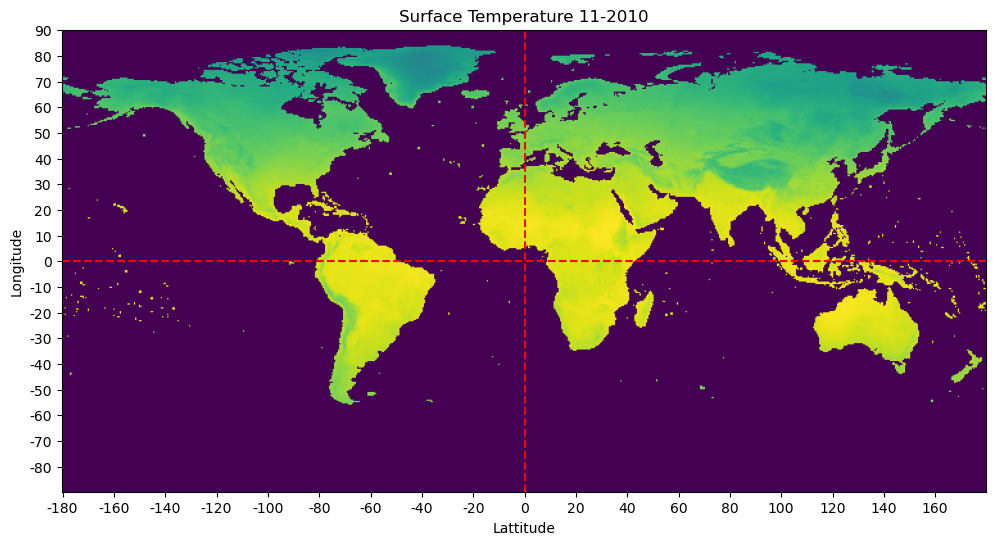

In [5]:
# fetch surface temp data
surf_temp = SurfaceTemperature()
surf_temp.fetch_data_years(1901, 2023, delete_file=True)

ax = surf_temp.plot_month(11, 2010)
plt.show()

In [216]:
data = surf_temp.get_month(11, 2000)
np.amin(data), np.amax(data)

(np.float64(-999.0), np.float64(315.0))

[  12.   57.  -13. ... -203. -202. -999.]


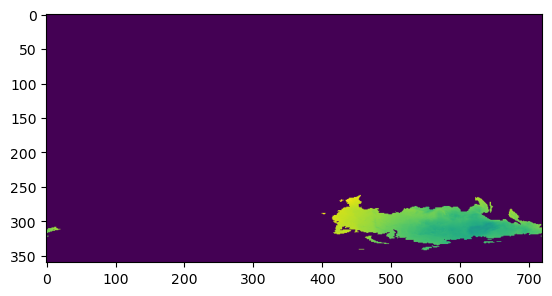

In [219]:
idx = world.get_grid_points_of_country('RUS')
test = np.ones(data.shape) * -999
test[idx] = data[idx]
plt.imshow(test)
print(data[idx])

# Create the world object and create lookup array

In [6]:
# create the world object
world = World('tests/aux_files/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world.create_lookup()

### Quick test to see if country selections make sense

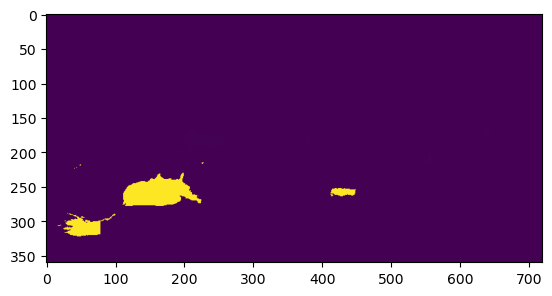

In [7]:
# quick test for selecting country
idx = world.get_grid_points_of_country(iso_code='TUR')
data = np.copy(rainfall.get_month(5, 2007))
data[idx] = 999999
idx = world.get_grid_points_of_country(iso_code='US1')
data[idx] = 999999
plt.imshow(data)
plt.show()

### Plot rainfall totals for Turkey and Syria, just as a test

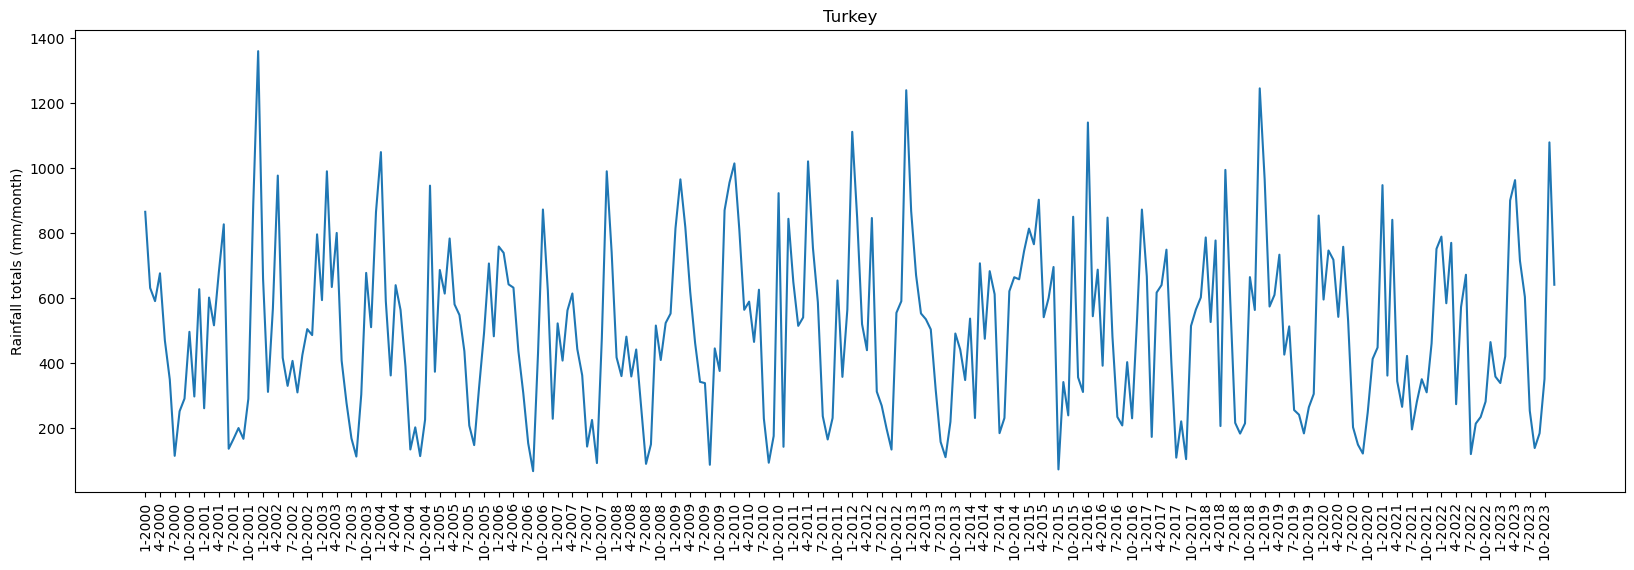

In [8]:
t, dates, totals = rainfall.get_country_avg((1,12), (2000,2023),'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::3])
ax.set_xticklabels(dates[::3], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Turkey')
plt.show()

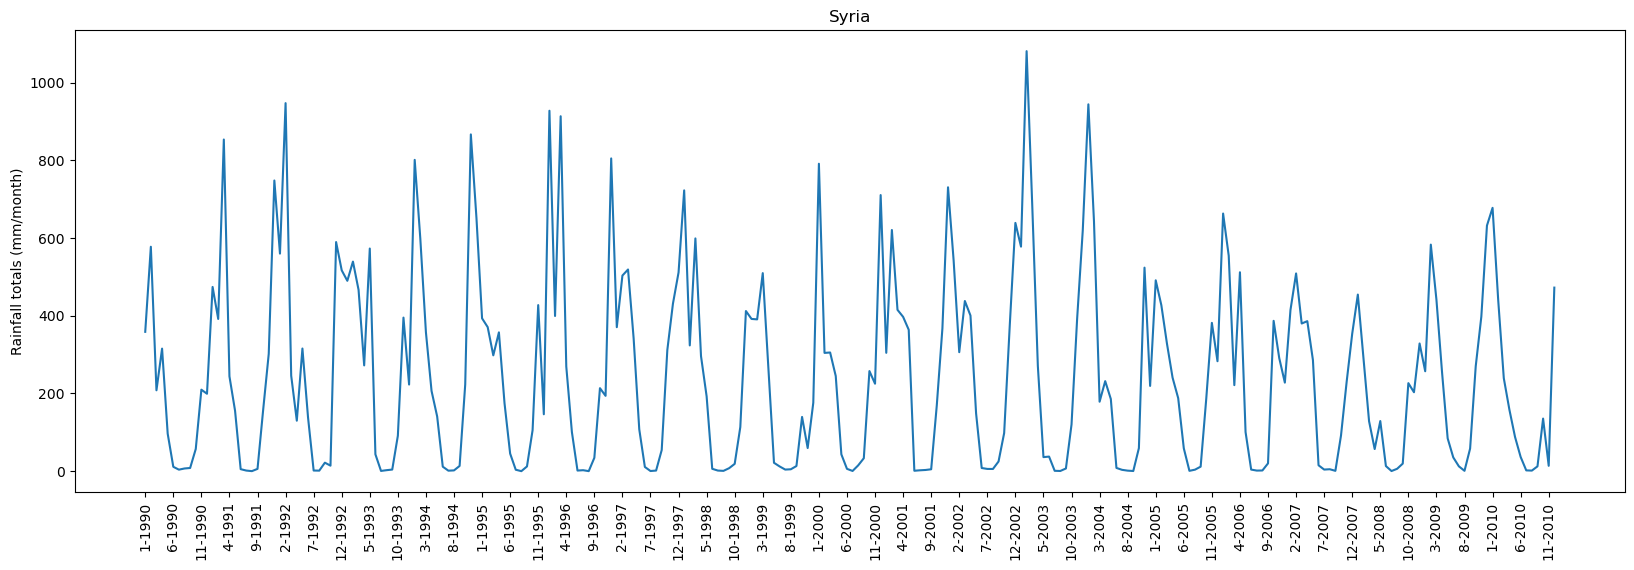

In [9]:
t, dates, totals = rainfall.get_country_avg((1,12), (1990,2010),'SYR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::5])
ax.set_xticklabels(dates[::5], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Syria')
plt.show()

### Syria 6-month winter averages (November-April) as plotted in Fig.1 of [Kelley et al.](https://www.pnas.org/doi/epdf/10.1073/pnas.1421533112)

The orange line is a moving average with a window of 50 years, meant to depict the overall decrease trend starting around ~1990.

p-value for pre 1930s temperature to be larger is 0.07485028305619477, with a test statistic of 1.4405899331246053.


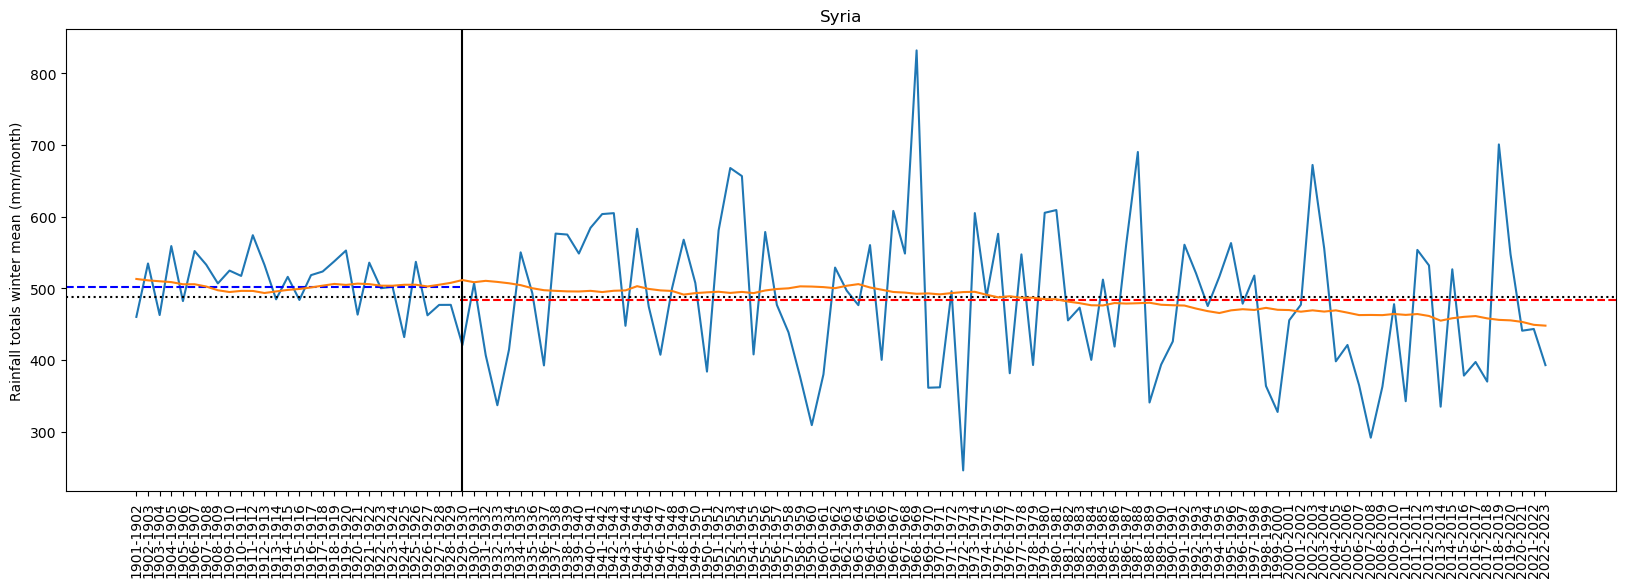

In [10]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)

# quick hypothesis testing with H_0: mu_1=mu_2, H_a: mu_2>mu_1
pre_30s = winter_means[:31]
post_30s = winter_means[31:]
pop_mean_diff = np.mean(post_30s)-np.mean(pre_30s)
z, p = ztest(x1=pre_30s, x2=post_30s, alternative='larger', usevar='unequal')
print(f"p-value for pre 1930s temperature to be larger is {p}, with a test statistic of {z}.")

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means)
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted')
ax.axhline(np.mean(winter_means[:31]), color='b', linestyle='dashed', xmax=31/len(dates))
ax.axhline(np.mean(winter_means[31:]), color='r', linestyle='dashed', xmin=31/len(dates))
ax.axvline(28, color='k')
ax.plot(t, movmean(winter_means, window=50))

ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Syria')
plt.show()

Try different cutoffs for the year for the z-test. (This is probably p-hacking)

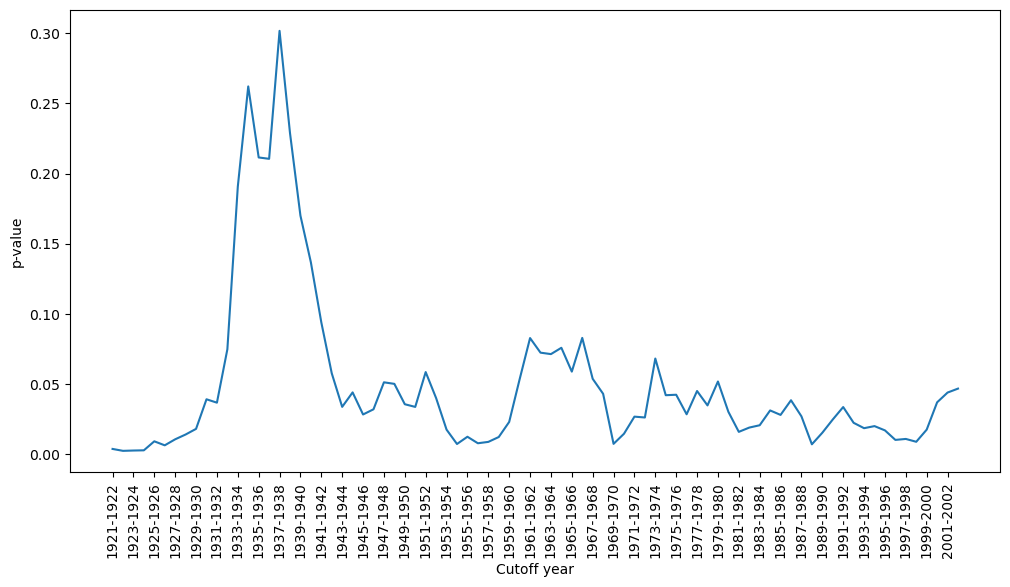

In [11]:
cutoffs = []
pvals = []
margin = 20
for i in range(margin,len(winter_means)-margin):
    pre = winter_means[:i]
    post = winter_means[i:]
    z, p = ztest(x1=pre, x2=post, alternative='larger', usevar='unequal')
    cutoffs.append(i)
    pvals.append(p)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(cutoffs, pvals)
ax.set_xlabel('Cutoff year')
ax.set_ylabel('p-value')
ax.set_xticks(cutoffs[::2])
ax.set_xticklabels(dates[margin:-margin][::2], rotation=90)
plt.show()

Same for Turkey, just out of curiosity. Note that a similar trend exists, but the total rainfall is an order of magnitude larger. This suggests to me that maybe if the total rainfall is large enough, the economical impacts of a drought may be more robust to rainfall variation. 

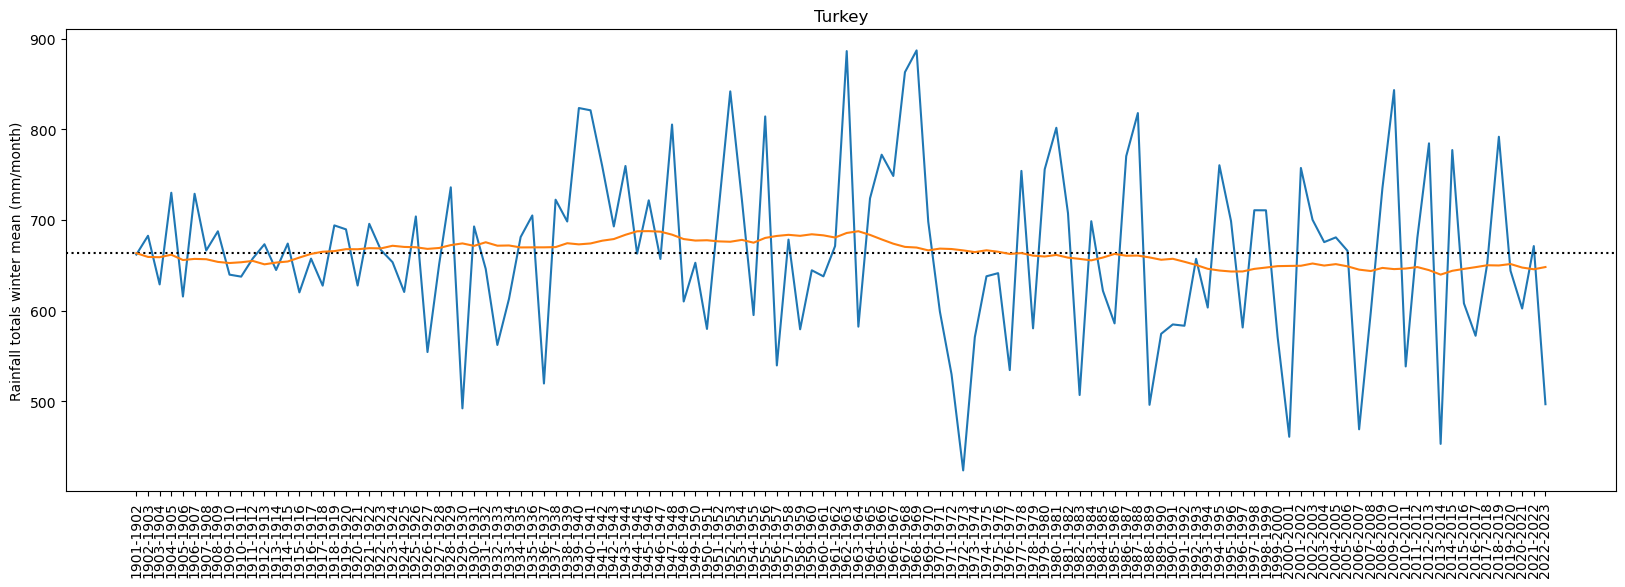

In [12]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means)
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted')
ax.plot(t, movmean(winter_means, window=50))
ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Turkey')
plt.show()

Rainfall variation (as numerical differentiation)

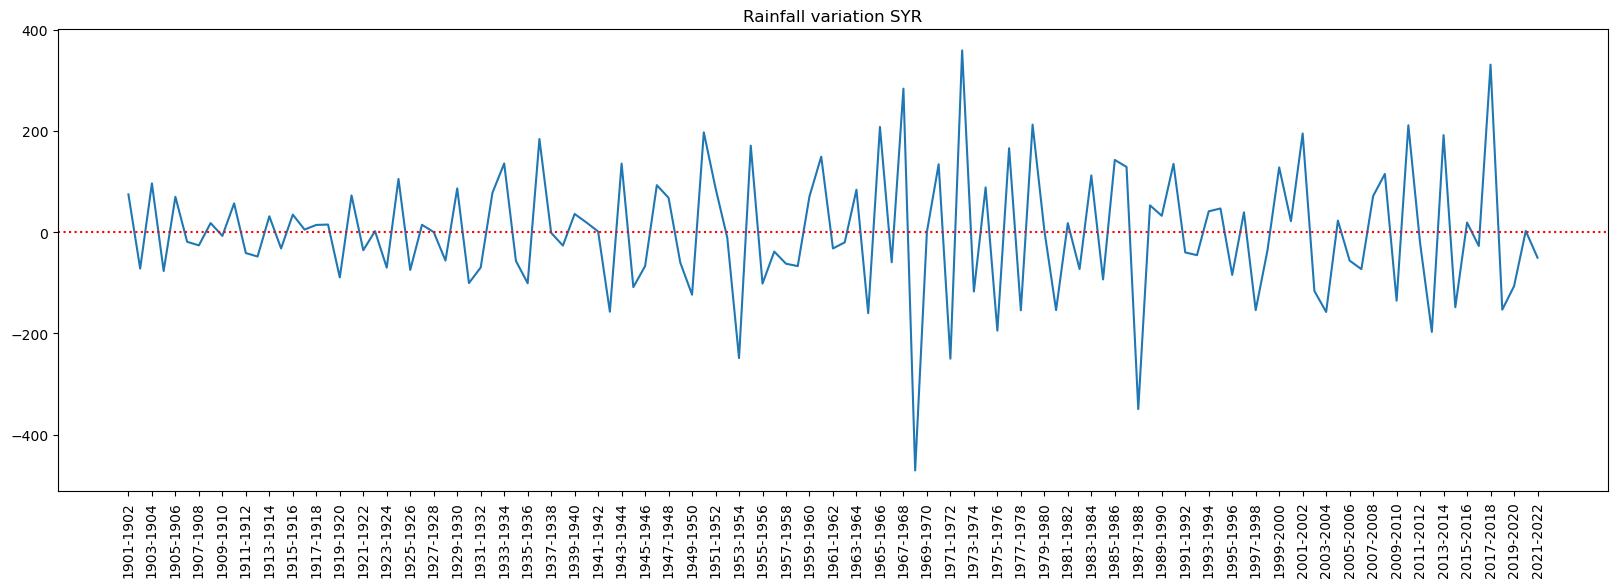

In [13]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
variation = np.diff(winter_means)
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(t[:-1], variation)
ax.set_xticks(t[::2])
ax.set_xticklabels(dates[::2], rotation=90)
ax.axhline(0, color='r', linestyle='dotted')
ax.set_title('Rainfall variation SYR')
plt.show()

Compare with GDP

In [14]:
df = pd.read_csv("https://ourworldindata.org/grapher/gdp-worldbank-constant-usd.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
df.head(5)

,Entity,Code,Year,ny_gdp_mktp_kd
0,Afghanistan,AFG,2000,6.206548e+09
1,Afghanistan,AFG,2001,5.621148e+09
2,Afghanistan,AFG,2002,7.228796e+09
3,Afghanistan,AFG,2003,7.867264e+09
4,Afghanistan,AFG,2004,7.978516e+09


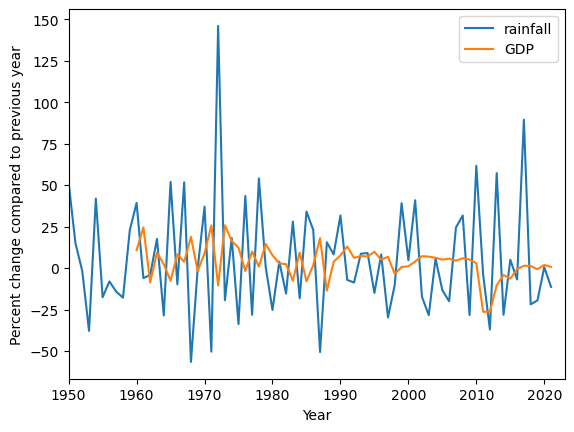

In [15]:
year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1901, 2022) 

plt.plot(tx, variation, label='rainfall')
plt.plot(year[:-1], gdp_var, label='GDP')
plt.xlabel('Year')
plt.ylabel('Percent change compared to previous year')
plt.xlim(1950,2023)
plt.legend()
plt.show()

[[0.         0.03477456]] 0.015191192251121977


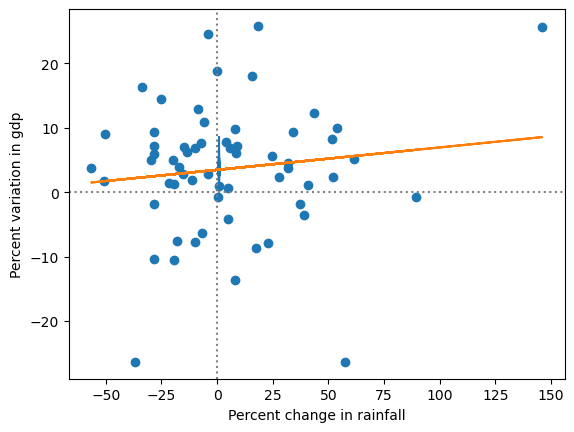

In [16]:
from sklearn.linear_model import LinearRegression

year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1961, 2022)

plt.scatter(variation[1:], gdp_var[:-1])
plt.xlabel('Percent change in rainfall')
plt.ylabel('Percent variation in gdp')
plt.axhline(0, color='gray', linestyle='dotted')
plt.axvline(0, color='gray', linestyle='dotted')

X = np.hstack((np.ones((len(variation[1:]), 1)), variation[1:].reshape(-1, 1)))
y = gdp_var[:-1].to_numpy().reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))
plt.plot(X, reg.predict(X))
plt.show()

[[     0.         603848.45102385]] 0.002775611096733299


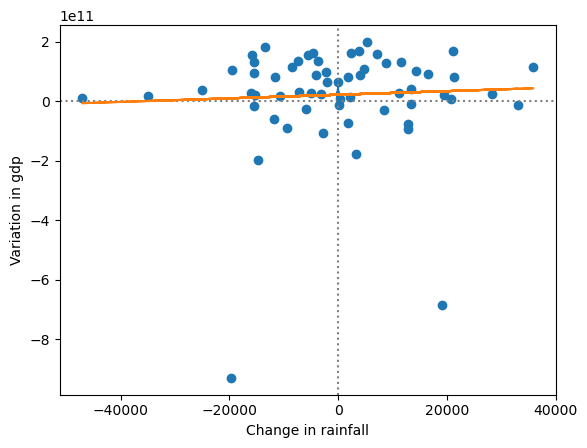

In [17]:
year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
variation = 100*np.diff(winter_means)

plt.scatter(variation[1:], gdp_var[:-1])
plt.xlabel('Change in rainfall')
plt.ylabel('Variation in gdp')
plt.axhline(0, color='gray', linestyle='dotted')
plt.axvline(0, color='gray', linestyle='dotted')

X = np.hstack((np.ones((len(variation[1:]), 1)), variation[1:].reshape(-1, 1)))
y = gdp_var[:-1].reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))
plt.plot(X, reg.predict(X))
plt.show()

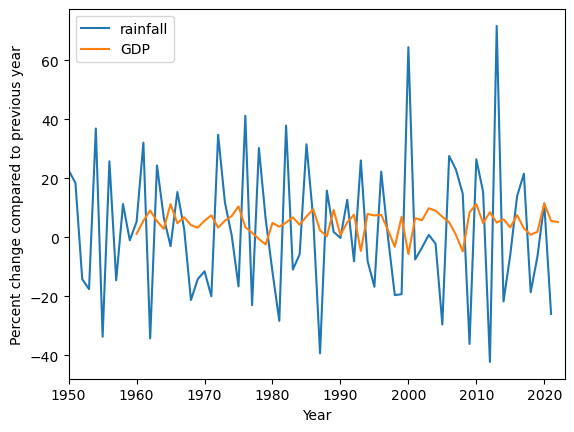

In [18]:
year = df[df['Code'] == 'TUR'].Year

gdp = df[df['Code'] == 'TUR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1901, 2022)

plt.plot(tx, variation, label='rainfall')
plt.plot(year[:-1], gdp_var, label='GDP')
plt.xlabel('Year')
plt.ylabel('Percent change compared to previous year')
plt.xlim(1950,2023)
plt.legend()
plt.show()

Function to calculate variations as described in [Miguel et al. 2004](http://emiguel.econ.berkeley.edu/wordpress/wp-content/uploads/2021/03/Paper__Economic_Shocks_and_Civil_Conflict.pdf)

In [19]:
from utils import diff

# Basic OLS attempts

1960 2022
63 63
[[ 0.         -0.05400169  0.08884867 -0.00192038]] 0.3197112384553029


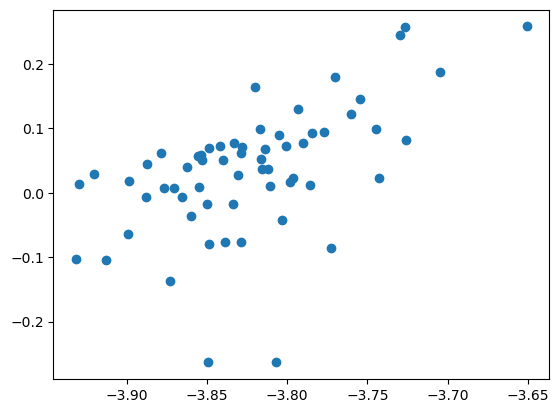

In [20]:
# design matrix roughly following the rainfall paper

year = df[df['Code'] == 'SYR'].Year
print(np.amin(year), np.amax(year))
gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
print(len(year), len(winter_means))

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))

plt.scatter(reg.coef_[0][0] + r_it[1:]*reg.coef_[0][1] + r_it_1*reg.coef_[0][2] +year[2:].to_numpy()*reg.coef_[0][3], gdp_var[1:])

1960 2023
63 63
[[ 0.00000000e+00 -4.59480862e-02 -9.64450884e-03 -7.11028183e-05]] 0.06976567207913531


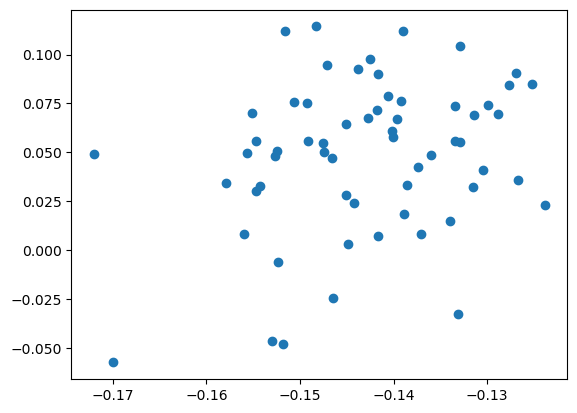

In [21]:
# design matrix roughly following the rainfall paper

year = df[df['Code'] == 'TUR'].Year
print(np.amin(year), np.amax(year))
year = year[:-1]

gdp = df[df['Code'] == 'TUR'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'TUR', world)
print(len(year), len(winter_means))

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))

plt.scatter(reg.coef_[0][0] + r_it[1:]*reg.coef_[0][1] + r_it_1*reg.coef_[0][2] +year[2:].to_numpy()*reg.coef_[0][3], gdp_var[1:])

1960 2023
63 63
[[ 0.          0.01435919 -0.01330404  0.00079599]] 0.02471973145890427


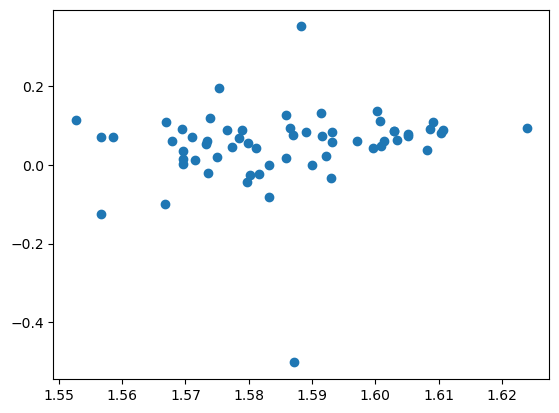

In [22]:
year = df[df['Code'] == 'RWA'].Year
print(np.amin(year), np.amax(year))
year = year[:-1]

gdp = df[df['Code'] == 'RWA'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'RWA', world)
print(len(year), len(winter_means))

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))

plt.scatter(reg.coef_[0][0] + r_it[1:]*reg.coef_[0][1] + r_it_1*reg.coef_[0][2] +year[2:].to_numpy()*reg.coef_[0][3], gdp_var[1:])

1960 2023
63 63
[[0.         0.02506661 0.01809996 0.00082745]] 0.04922830434691261
0.04922830434691261


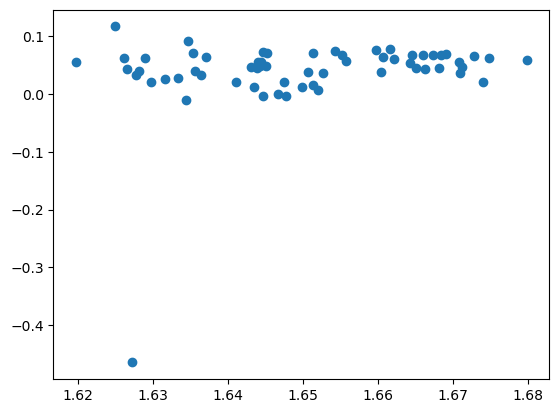

In [23]:
year = df[df['Code'] == 'TZA'].Year
print(np.amin(year), np.amax(year))
year = year[:-1]

gdp = df[df['Code'] == 'TZA'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'TZA', world)
print(len(year), len(winter_means))

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))

plt.scatter(reg.coef_[0][0] + r_it[1:]*reg.coef_[0][1] + r_it_1*reg.coef_[0][2] +year[2:].to_numpy()*reg.coef_[0][3], gdp_var[1:])
print(reg.score(X, y))

# Join multiple datasets

- Annual GDP data
- Annual winter rainfall data
- Share of GDP from agriculture
- Oil rents as a share of GDP
- Democracy index Polity V
- Ethnic fractionalization index

In [151]:
from csv_fetcher import CsvFetcher

In [152]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/agriculture-share-gdp.csv?v=1&csvType=full&useColumnShortNames=true')
agricultural_share = fetcher.fetch()
agricultural_share.head(5)

iso_name = agricultural_share.copy()
iso_name = iso_name[['Entity', 'Code']].drop_duplicates(ignore_index=True)

In [153]:
agricultural_share[agricultural_share.isna().any(axis=1)]

# remove region info
agricultural_share.dropna(inplace=True)


In [154]:
iso_name

,Entity,Code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,Andorra,AND
4,Angola,AGO
...,...,...
215,Vietnam,VNM
216,World,OWID_WRL
217,Yemen,YEM
218,Zambia,ZMB


In [155]:
print(agricultural_share['Code'].unique(), agricultural_share['Code'].nunique())

['AFG' 'ALB' 'DZA' 'AND' 'AGO' 'ATG' 'ARG' 'ARM' 'ABW' 'AUS' 'AUT' 'AZE'
 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ' 'BEN' 'BMU' 'BTN' 'BOL' 'BIH'
 'BWA' 'BRA' 'BRN' 'BGR' 'BFA' 'BDI' 'KHM' 'CMR' 'CAN' 'CPV' 'CYM' 'CAF'
 'TCD' 'OWID_CIS' 'CHL' 'CHN' 'COL' 'COM' 'COG' 'CRI' 'CIV' 'HRV' 'CUB'
 'CUW' 'CYP' 'CZE' 'COD' 'DNK' 'DJI' 'DMA' 'DOM' 'TLS' 'ECU' 'EGY' 'SLV'
 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH' 'FJI' 'FIN' 'FRA' 'PYF' 'GAB' 'GMB' 'GEO'
 'DEU' 'GHA' 'GRC' 'GRL' 'GRD' 'GTM' 'GIN' 'GNB' 'GUY' 'HTI' 'HND' 'HKG'
 'HUN' 'ISL' 'IND' 'IDN' 'IRN' 'IRQ' 'IRL' 'IMN' 'ISR' 'ITA' 'JAM' 'JPN'
 'JOR' 'KAZ' 'KEN' 'KIR' 'OWID_KOS' 'KWT' 'KGZ' 'LAO' 'LVA' 'LBN' 'LSO'
 'LBR' 'LBY' 'LIE' 'LTU' 'LUX' 'MDG' 'MWI' 'MYS' 'MDV' 'MLI' 'MLT' 'MHL'
 'MRT' 'MUS' 'MEX' 'FSM' 'MDA' 'MNG' 'MNE' 'MAR' 'MOZ' 'MMR' 'NAM' 'NPL'
 'NLD' 'NCL' 'NZL' 'NIC' 'NER' 'NGA' 'MKD' 'NOR' 'OMN' 'PAK' 'PLW' 'PSE'
 'PAN' 'PNG' 'PRY' 'PER' 'PHL' 'POL' 'PRT' 'PRI' 'QAT' 'ROU' 'RUS' 'RWA'
 'KNA' 'LCA' 'VCT' 'WSM' 'SMR' 'STP' 'SAU' 'SEN' 'SRB

In [156]:
from missing_value_handler import add_missing_years, fill_na

In [157]:
agricultural_share = add_missing_years(agricultural_share,
                                       min_year=1960,
                                       max_year=2023,
                                       year_name='Year',
                                       ref_column='Code')

In [158]:
agricultural_share[agricultural_share['Code']=='AFG']
agricultural_share = agricultural_share.drop('Entity', axis=1)

In [159]:
fill_na(agricultural_share, 'nv_agr_totl_zs', 'Code', 'AFG', method='max')
agricultural_share[agricultural_share['Code']=='AFG']

,Code,Year,nv_agr_totl_zs
0,AFG,2002,38.627890
1,AFG,2003,37.418854
2,AFG,2004,29.721067
3,AFG,2005,31.114855
4,AFG,2006,28.635970
...,...,...,...
0,AFG,1997,38.627890
0,AFG,1998,38.627890
0,AFG,1999,38.627890
0,AFG,2000,38.627890


In [160]:
# do the same to all the other countries
for country in agricultural_share['Code'].unique():
    fill_na(agricultural_share, 'nv_agr_totl_zs', 'Code', country, method='max')

agricultural_share = agricultural_share.sort_values(by=['Code','Year'])

In [161]:
agricultural_share.sample(10)

,Code,Year,nv_agr_totl_zs
0,KGZ,1965,46.317623
1982,CUB,2018,3.782373
4412,KWT,1995,0.419034
5654,MAR,1999,12.476640
160,ATG,2009,1.112091
6339,PAK,2012,23.386196
0,SRB,1960,15.711183
0,SLB,1961,64.673230
0,LIE,1969,0.211170
1109,BFA,1967,33.411980


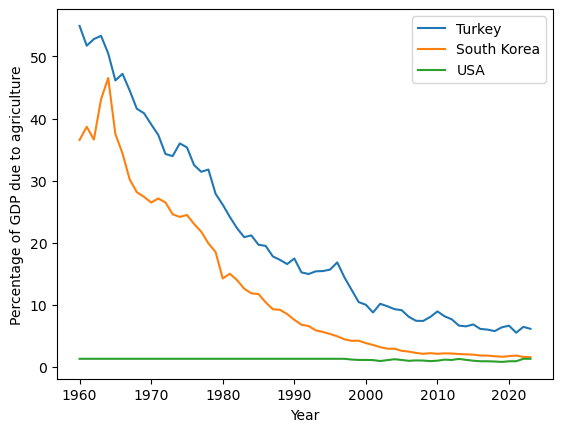

In [162]:
test = agricultural_share[agricultural_share['Code']=='TUR']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='Turkey')

test = agricultural_share[agricultural_share['Code']=='KOR']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='South Korea')

test = agricultural_share[agricultural_share['Code']=='USA']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='USA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of GDP due to agriculture')
plt.show()

In [163]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/oil-rents-as-a-share-of-gdp.csv?v=1&csvType=full&useColumnShortNames=true')
oil_rent = fetcher.fetch()
oil_rent = oil_rent.drop('Entity', axis=1)
oil_rent = oil_rent.dropna()
oil_rent = add_missing_years(oil_rent,
                             min_year=1960,
                             max_year=2023,
                             year_name='Year',
                             ref_column='Code')

for country in oil_rent['Code'].unique():
    fill_na(oil_rent, 'ny_gdp_petr_rt_zs', 'Code', country, method='min')

oil_rent = oil_rent.sort_values(by=['Code', 'Year'])
oil_rent.reset_index(drop=True, inplace=True)

oil_rent.sample(10)

,Code,Year,ny_gdp_petr_rt_zs
10240,SLE,1960,0.000000
2130,CHL,1978,0.582775
2985,CZE,2001,0.024458
5525,ISL,1981,0.000000
6329,KOR,2017,0.015613
2055,CHE,1967,0.000000
11966,UKR,2022,0.181695
11835,TZA,2019,0.000000
2639,CPV,1975,0.000000
3820,FIN,2004,0.000189


In [164]:
oil_rent[oil_rent.isna().any(axis=1)]

,Code,Year,ny_gdp_petr_rt_zs


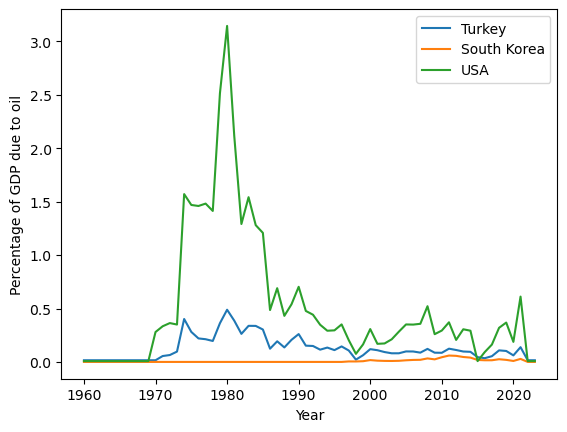

In [165]:
test = oil_rent[oil_rent['Code']=='TUR']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='Turkey')

test = oil_rent[oil_rent['Code']=='KOR']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='South Korea')

test = oil_rent[oil_rent['Code']=='USA']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of GDP due to oil') # is this true?
plt.show()

In [166]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/democracy-index-polity.csv?v=1&csvType=full&useColumnShortNames=true')
democracy_index = fetcher.fetch()
democracy_index = democracy_index.drop('Entity', axis=1)
democracy_index = add_missing_years(democracy_index,
                                    min_year=1960,
                                    max_year=2023,
                                    year_name='Year',
                                    ref_column='Code')

for country in democracy_index['Code'].unique():
    fill_na(democracy_index, 'democracy_polity', 'Code', country, method='mean')

democracy_index = democracy_index.sort_values(by=['Code','Year'])

democracy_index.head(5)

,Code,Year,democracy_polity
0,AFG,1800,-6.0
1,AFG,1801,-6.0
2,AFG,1802,-6.0
3,AFG,1803,-6.0
4,AFG,1804,-6.0


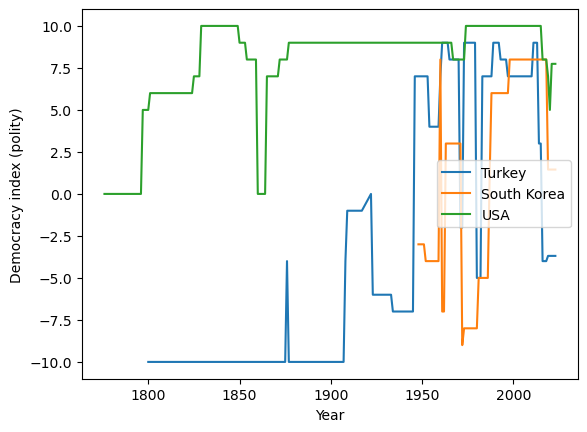

In [167]:
test = democracy_index[democracy_index['Code'] == 'TUR']
plt.plot(test['Year'], test['democracy_polity'], label='Turkey')

test = democracy_index[democracy_index['Code'] == 'KOR']
plt.plot(test['Year'], test['democracy_polity'], label='South Korea')

test = democracy_index[democracy_index['Code'] == 'USA']
plt.plot(test['Year'], test['democracy_polity'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Democracy index (polity)')
plt.show()

In [181]:
fetcher = CsvFetcher('https://cadmus.eui.eu/bitstream/handle/1814/64606/Historical_Index_of_Ethnic_Fractionalisation_Dataset.csv?sequence=3&isAllowed=y')
ethnic_fractionation = fetcher.fetch()
ethnic_fractionation = add_missing_years(ethnic_fractionation,
                                         min_year=1960,
                                         max_year=2023,
                                         year_name='Year',
                                         ref_column='Country')

for country in ethnic_fractionation['Country'].unique():
    fill_na(ethnic_fractionation, 'EFindex', 'Country', country, method='max')

ethnic_fractionation = ethnic_fractionation.sort_values(by=['Country', 'Year'])
ethnic_fractionation.rename(columns={'Country':'Entity'}, inplace=True)
ethnic_fractionation.sample(10)

,Entity,Year,EFindex
7416,Taiwan,1965,0.208
0,Singapore,2017,0.395
0,Malaysia,2016,0.603
3771,South Africa,1966,0.855
0,Chile,2022,0.533
5928,Chile,1975,0.494
0,Georgia,1987,0.511
0,Serbia,1982,0.596
7699,Bhutan,1978,0.565
3481,Ethiopia,1954,0.804


In [169]:
print(ethnic_fractionation['Country'].unique(), ethnic_fractionation['Country'].nunique())

['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia-Herzegovina' 'Botswana'
 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Canada'
 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Czechoslovakia' "Democratic People's Republic of Korea"
 'Democratic Republic of Congo' 'Democratic Republic of Vietnam' 'Denmark'
 'Djibouti' 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt'
 'El Salvador' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'Gabon'
 'Gambia' 'Georgia' 'German Democratic Republic' 'German Federal Republic'
 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'Hungary' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Kuwait'
 'Kyrgyz Republ

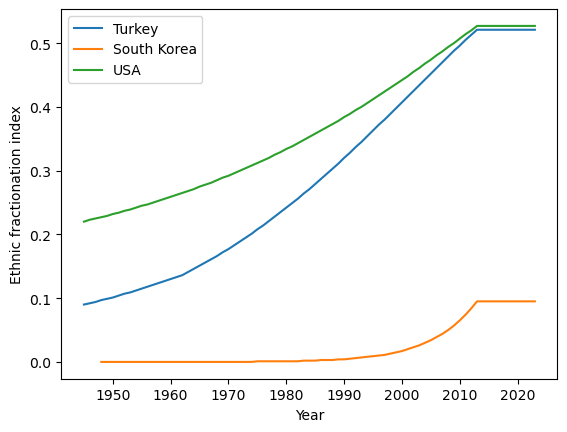

In [170]:
test = ethnic_fractionation[ethnic_fractionation['Country']=='Turkey']
plt.plot(test['Year'], test['EFindex'], label='Turkey')

test = ethnic_fractionation[ethnic_fractionation['Country']=='Republic of Korea']
plt.plot(test['Year'], test['EFindex'], label='South Korea')

test = ethnic_fractionation[ethnic_fractionation['Country']=='United States of America']
plt.plot(test['Year'], test['EFindex'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Ethnic fractionation index')
plt.show()

In [171]:
# our gdp dataset we downloaded above
df = pd.read_csv("https://ourworldindata.org/grapher/gdp-worldbank-constant-usd.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

df = df.drop('Entity', axis=1)
df = add_missing_years(df, min_year=1960,
                       max_year=2023,
                       year_name='Year',
                       ref_column='Code')

for country in df['Code'].unique():
    fill_na(df, 'ny_gdp_mktp_kd', 'Code', country, method='min')

df = df.sort_values(by=['Code', 'Year'])

df.sample(5)

,Code,Year,ny_gdp_mktp_kd
6281,NaN,1969,6.332206e+11
4273,GUM,2016,5.809553e+09
3050,EGY,1960,2.029783e+10
8401,PSE,1997,6.287800e+09
5840,LAO,2009,9.133631e+09


In [172]:
df[df['Code']=='AFG']['Year']

0     1960
0     1961
0     1962
0     1963
0     1964
      ... 
19    2019
20    2020
21    2021
22    2022
23    2023
Name: Year, Length: 64, dtype: int64

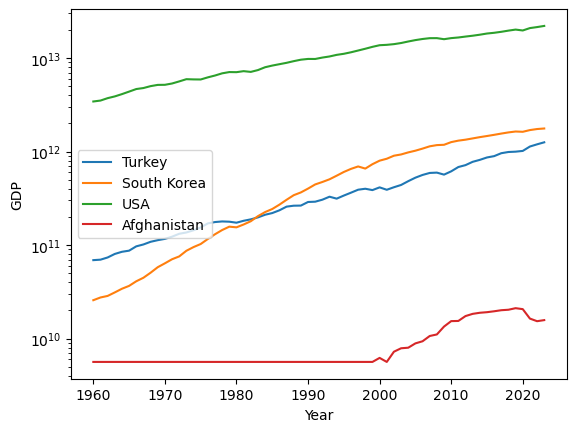

In [173]:
test = df[df['Code']=='TUR']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='Turkey')

test = df[df['Code']=='KOR']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='South Korea')

test = df[df['Code']=='USA']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='USA')

test = df[df['Code']=='AFG']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='Afghanistan')


plt.legend()
plt.xlabel('Year')
plt.ylabel('GDP')
plt.yscale('log')
plt.show()

In [174]:
agricultural_share[['Code', 'Year']].nunique(), oil_rent[['Code', 'Year']].nunique()

(Code    206
 Year     64
 dtype: int64,
 Code    200
 Year     64
 dtype: int64)

In [182]:
ethnic_fractionation_with_code = ethnic_fractionation.merge(iso_name, on=['Entity'])
ethnic_fractionation_with_code.sample(10)

,Entity,Year,EFindex,Code
220,Algeria,2022,0.372,DZA
5660,Lithuania,1960,0.346,LTU
9772,Ukraine,2007,0.387,UKR
3964,Guinea,2018,0.753,GIN
9830,United Arab Emirates,2001,0.687,ARE
4299,Hungary,1985,0.090,HUN
9506,Tunisia,2013,0.034,TUN
6119,Mexico,1953,0.532,MEX
3948,Guinea,2002,0.735,GIN
2607,Democratic Republic of Congo,2017,0.816,COD


### Finally joining datasets

In [185]:
new_df = agricultural_share.merge(oil_rent, on=['Code', 'Year'])
new_df = new_df.merge(democracy_index, on=['Code', 'Year'])
new_df = new_df.merge(df, on=['Code', 'Year'])
new_df = new_df.merge(ethnic_fractionation_with_code, on=['Code', 'Year'])

new_df.rename(columns={'Code':'ISO3_code',
                       'nv_agr_totl_zs':'pt_gdp_agriculture',
                       'nv_gdp_petr_rt_zs':'pt_gdp_oil',
                       'ny_gdp_mktp_kd':'gdp',
                       'Entity':'country',
                       'EFindex': 'ethnic_fractionation_index'},
                       inplace=True)
new_df.reset_index(drop=True, inplace=True)
new_df.sample(20)

,ISO3_code,Year,pt_gdp_agriculture,ny_gdp_petr_rt_zs,democracy_polity,gdp,country,ethnic_fractionation_index
9116,ZWE,1968,16.903252,0.000000,-1.692308,5.773351e+09,Zimbabwe,0.379
242,ARE,2010,0.735026,22.679737,-8.000000,2.929686e+11,United Arab Emirates,0.688
2203,CYP,1984,8.942722,0.000000,10.000000,6.777619e+09,Cyprus,0.341
409,AUS,1982,4.193446,1.143926,10.000000,4.818879e+11,Australia,0.066
1185,BRA,1990,6.963437,1.030887,8.000000,9.172111e+11,Brazil,0.567
8472,TTO,1966,6.705892,1.429246,4.000000,5.059495e+09,Trinidad and Tobago,0.629
1001,BHR,1998,0.337284,10.637696,-9.000000,1.475004e+10,Bahrain,0.528
2618,EGY,2015,11.394061,3.055264,-4.000000,3.293666e+11,Egypt,0.041
2765,EST,1970,5.051828,0.233222,-7.000000,9.855880e+09,Estonia,0.520
7388,SEN,1970,23.719143,0.000000,-7.000000,4.647265e+09,Senegal,0.798


## Add rainfall and surface temp data

In [187]:
countries = new_df['ISO3_code'].unique()
print(countries, len(countries))

['AFG' 'AGO' 'ALB' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN'
 'BFA' 'BGD' 'BGR' 'BHR' 'BLR' 'BOL' 'BRA' 'BTN' 'BWA' 'CAF' 'CAN' 'CHE'
 'CHL' 'CHN' 'CIV' 'COD' 'COG' 'COL' 'COM' 'CPV' 'CRI' 'CUB' 'CYP' 'DJI'
 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'GAB'
 'GBR' 'GEO' 'GHA' 'GIN' 'GMB' 'GNB' 'GRC' 'GTM' 'GUY' 'HND' 'HRV' 'HTI'
 'HUN' 'IDN' 'IRL' 'IRN' 'IRQ' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KAZ' 'KEN'
 'KHM' 'KWT' 'LAO' 'LBN' 'LBR' 'LBY' 'LKA' 'LSO' 'LTU' 'LVA' 'MAR' 'MDA'
 'MDG' 'MEX' 'MLI' 'MMR' 'MNG' 'MRT' 'MUS' 'MWI' 'MYS' 'NAM' 'NER' 'NGA'
 'NIC' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'POL' 'PRT'
 'PRY' 'QAT' 'ROU' 'RUS' 'RWA' 'SAU' 'SDN' 'SEN' 'SGP' 'SLB' 'SLE' 'SLV'
 'SOM' 'SRB' 'SVK' 'SVN' 'SWE' 'SYR' 'TCD' 'TGO' 'THA' 'TJK' 'TKM' 'TLS'
 'TTO' 'TUN' 'TUR' 'TZA' 'UGA' 'UKR' 'URY' 'UZB' 'ZAF' 'ZMB' 'ZWE'] 143


In [210]:
yearly_rainfall = pd.DataFrame()
yearly_temp_avg = pd.DataFrame()
for country in countries:
    try:
        t, years, averages = rainfall.get_country_annual_avg((1960, 2023), country, world)
        to_add = pd.DataFrame({'ISO3_code': [country]*len(t), 'Year': years, 'yearly_avg_rainfall': averages})
        yearly_rainfall = pd.concat([yearly_rainfall, to_add])

        t, years, averages = surf_temp.get_country_annual_avg((1960, 2023), country, world)
        to_add = pd.DataFrame({'ISO3_code': [country]*len(t), 'Year': years, 'yearly_avg_temp': averages})
        yearly_temp_avg = pd.concat([yearly_temp_avg, to_add])
    except:
        continue

In [207]:
yearly_rainfall

,ISO3_code,Year,yearly_avg_rainfall
0,AFG,1960,318.565807
1,AFG,1961,294.653108
2,AFG,1962,243.503638
3,AFG,1963,307.702050
4,AFG,1964,300.362434
...,...,...,...
59,ZWE,2019,647.373718
60,ZWE,2020,586.835256
61,ZWE,2021,543.462821
62,ZWE,2022,635.176282


In [208]:
new_df = new_df.merge(yearly_rainfall, on=['ISO3_code', 'Year'])

In [209]:
new_df

,ISO3_code,Year,pt_gdp_agriculture,ny_gdp_petr_rt_zs,democracy_polity,gdp,country,ethnic_fractionation_index,yearly_avg_rainfall
0,AFG,1960,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.586,318.565807
1,AFG,1961,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.588,294.653108
2,AFG,1962,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.591,243.503638
3,AFG,1963,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.593,307.702050
4,AFG,1964,38.627890,0.005149,-7.000000,5.621148e+09,Afghanistan,0.596,300.362434
...,...,...,...,...,...,...,...,...,...
8205,ZWE,2019,9.819262,0.050883,-1.692308,2.062108e+10,Zimbabwe,0.415,647.373718
8206,ZWE,2020,8.772859,0.029129,-1.692308,1.900914e+10,Zimbabwe,0.415,586.835256
8207,ZWE,2021,8.849899,0.047769,-1.692308,2.061884e+10,Zimbabwe,0.415,543.462821
8208,ZWE,2022,7.170550,0.000000,-1.692308,2.188468e+10,Zimbabwe,0.415,635.176282


In [211]:
yearly_temp_avg

,ISO3_code,Year,yearly_avg_temp
0,AFG,1960,116.206019
1,AFG,1961,120.477183
2,AFG,1962,117.250992
3,AFG,1963,126.046296
4,AFG,1964,110.172619
...,...,...,...
59,ZWE,2019,224.837821
60,ZWE,2020,220.788462
61,ZWE,2021,220.451923
62,ZWE,2022,219.669872
